# Dask Parallelization

In this notebook, we will explore the performance of the coordinate descent solver
when it uses Dask to parallelize the most time-consuming parts.

In [1]:
import numpy as np
import dask
import dask.array as da
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster
from memory_profiler import memory_usage
import matplotlib.pyplot as plt

from hsic_optimization.benchmark import generate_data
from hsic_optimization.hsic_lasso import cd_hsic_lasso, feature_accel
from hsic_optimization.optimization import cd_nn_lasso_path  # NOQA

The following configuration ensures that Dask doesn't use storage space when a
runner run out of memory.

In [2]:
_ = dask.config.set(
    {
        "distributed.worker.memory.target": False,  # avoid spilling to disk
        "distributed.worker.memory.spill": False,  # avoid spilling to disk
    }
)

## Dataset and parameter generation

We generate a large enough dataset to make it challenging for the current
implementation.

In [3]:
block_size = 20
n_repeats = 3

n_samples = 20000
n_features = 1000
n_active = 10

X, Y = generate_data(n_samples, n_features, n_active, seed=1234, transpose_X=True)

And we define the CD solver parameters common to all tested cases.

In [4]:
cd_hsic_kwargs = {
    "Y": Y,
    "B": block_size,
    "M": n_repeats,
    "num_feat": 10,
    "feature": feature_accel,
}

## Serial code

CPU times: user 6min 38s, sys: 264 ms, total: 6min 38s
Wall time: 6min 39s


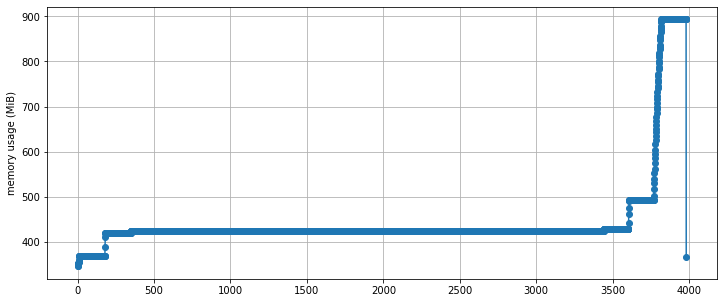

In [5]:
%%time
mem_use, (path_serial, beta_serial, lams_serial) = memory_usage(
    (cd_hsic_lasso, (X,), cd_hsic_kwargs), retval=True
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

## Processed-based parallelism

In [6]:
cluster = LocalCluster(
    n_workers=4,
    threads_per_worker=1,
    memory_limit="1GiB",
    processes=True,
    local_directory="../dask",
)
client = Client(cluster)

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43240,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://192.168.94.148:36734,Total threads: 1
Dashboard: http://192.168.94.148:35154/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:46300,


In [8]:
X_dist = da.from_array(X, chunks={0: 20})

In [9]:
X_dist

dask.array<array, shape=(1000, 20000), dtype=int64, chunksize=(20, 20000), chunktype=numpy.ndarray>

CPU times: user 23.1 s, sys: 8.32 s, total: 31.4 s
Wall time: 4min 7s


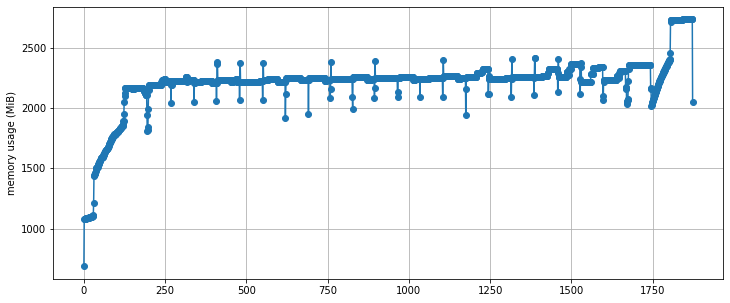

In [10]:
%%time
mem_use, (path_par, beta_par, lams_par) = memory_usage(
    (cd_hsic_lasso, (X_dist,), {"client": client, **cd_hsic_kwargs}),
    include_children=True,
    retval=True,
)

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

In [11]:
cluster.close()
client.close()

We check that the results for serial and parallel code are exactly the same.

In [12]:
np.all(path_serial.toarray() == path_par.toarray())

True

## Slurm-based parallelism

In [13]:
cluster = SLURMCluster(
    cores=2,
    processes=2,
    memory="2GiB",
    walltime="0-00:10",
    log_directory="../dask/logs",
    local_directory="../dask",
)
client = Client(cluster)

In [14]:
cluster.scale(n=4)
client.wait_for_workers(1)

In [15]:
X_dist = da.from_array(X, chunks={0: 20})
X_dist = client.persist(X_dist)

CPU times: user 25.2 s, sys: 2 s, total: 27.2 s
Wall time: 4min 38s


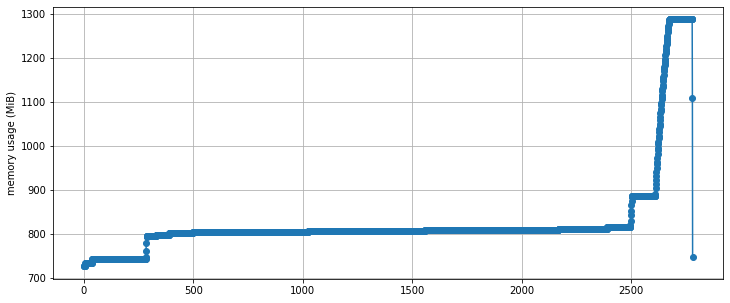

In [16]:
%%time
mem_use = memory_usage((cd_hsic_lasso, (X_dist,), {"client": client, **cd_hsic_kwargs}))

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

In [17]:
cluster.close()
client.close()

## Large-scale parallelism

We can use much larger amount of workers and smaller chunksize to reduce runtime.

In [18]:
cluster = SLURMCluster(
    cores=2,
    processes=2,
    memory="2GiB",
    walltime="0-00:10",
    log_directory="../dask/logs",
    local_directory="../dask",
)
client = Client(cluster)

In [19]:
cluster.scale(n=50)
client.wait_for_workers(1)

In [20]:
X_dist = da.from_array(X, chunks={0: 20})
X_dist = client.persist(X_dist)

CPU times: user 21 s, sys: 1.45 s, total: 22.4 s
Wall time: 1min 9s


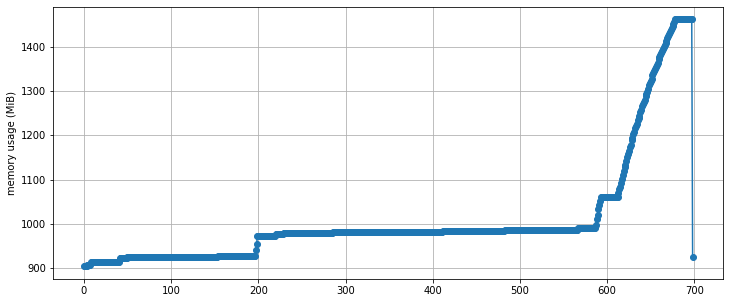

In [21]:
%%time
mem_use = memory_usage((cd_hsic_lasso, (X_dist,), {"client": client, **cd_hsic_kwargs}))

_, ax = plt.subplots(figsize=(12, 5))
ax.plot(mem_use, "-o")
ax.grid(True)
_ = ax.set_ylabel("memory usage (MiB)")

We can also profile this to check if now time is spent elsewhere than in features
screening.

In [22]:
%load_ext line_profiler

In [23]:
%lprun -f cd_nn_lasso_path cd_hsic_lasso(X_dist, client=client, **cd_hsic_kwargs)

Timer unit: 1e-06 s

Total time: 52.8005 s
File: /scale_wlg_persistent/filesets/project/nesi99999/riom/hsic_optimization/src/hsic_optimization/optimization.py
Function: cd_nn_lasso_path at line 102

Line #      Hits         Time  Per Hit   % Time  Line Contents
   102                                           def cd_nn_lasso_path(
   103                                               features: T.Union[np.ndarray, Operator],
   104                                               y: np.ndarray,
   105                                               max_features: int,
   106                                               eps: float = 0.95,
   107                                               max_outer_iter: int = 100,
   108                                               max_inner_iter: int = 2000,
   109                                               abstol: float = 1e-6,
   110                                           ) -> T.Tuple[sp.lil_matrix, np.ndarray, np.ndarray]:
   111                 

In [24]:
cluster.close()
client.close()